In [1]:
%env CUDA_VISIBLE_DEVICES=8

env: CUDA_VISIBLE_DEVICES=8


In [2]:
import sys
sys.path.append("../src/")

import json

from optim.utils import load_checkpoint
from models.utils import get_model


class DotDict(dict):
    def __getattr__(self, key):
        try:
            return self[key]
        except KeyError:
            raise AttributeError(f"'DotDict' object has no attribute '{key}'")

    def __setattr__(self, key, value):
        self[key] = value


PATH = "/nfs/scistore19/alistgrp/apanfero/models/UNTIED-30M-NoQuantizer@16:NoQuantizer@16:NoQuantizer@16:EW_EtX-c4_c4_llama_nlayers6_nhead5_lr0.0012_sched_cos_warmup1144_decay_linear_0.1_iter11444_bs64x1_ws8_seed0_data_seed1337"
with open(f"{PATH}/summary.json", "r") as f:
    config = json.load(f)


In [3]:
import torch
from torch import nn
import torch.nn.functional as F

from models.quantization.backward import QEQWtt_QEtQXtt_Scheme

In [4]:
from models.quantization import QuantizedLinear
from models.quantization.quantizers import NoQuantizer, AlbertTsengQuantizer, QuestMXFP4Quantizer, AlignedAlbertTsengQuantizer

BACKWARD_QUANTIZERS = {
    "NoQuantizer": NoQuantizer(),
    "AlbertTsengQuantizer": AlbertTsengQuantizer(stochastic=True, rerotate="signs"),
    "AlbertTsengDeterministic": AlbertTsengQuantizer(stochastic=False, rerotate="signs"),
    "QuestMXFP4Quantizer": QuestMXFP4Quantizer(rerotate="signs"),
    "AlignedAlbertTsengQuantizer": AlignedAlbertTsengQuantizer(rerotate="signs"),
}

BACKWARD_QUANTIZER = "NoQuantizer"
# BACKWARD_QUANTIZER = "AlbertTsengQuantizer"
# BACKWARD_QUANTIZER = "AlbertTsengDeterministic"
# BACKWARD_QUANTIZER = "QuestMXFP4Quantizer"
# BACKWARD_QUANTIZER = "AlignedAlbertTsengQuantizer"



INPUT_GRADIENTS = {key: {} for key in BACKWARD_QUANTIZERS.keys()}
OUTPUT_GRADIENTS = {key: {} for key in BACKWARD_QUANTIZERS.keys()}

class GradLogger(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, name, is_input):
        ctx.name = name
        ctx.is_input = is_input
        return x
    
    @staticmethod
    def backward(ctx, grad_output):
        name = ctx.name
        
        if ctx.is_input:
            INPUT_GRADIENTS[BACKWARD_QUANTIZER][name] = grad_output.clone().to(torch.bfloat16).cpu()
        else:
            OUTPUT_GRADIENTS[BACKWARD_QUANTIZER][name] = grad_output.clone().to(torch.bfloat16).cpu()
        return grad_output, None, None


class LinearLoggerBackward(nn.Module):
    def __init__(self, quantizer_linear, name):
        super().__init__()
        
        self.register_buffer("weight", quantizer_linear.weight)
        
        self.name = name
        self.backward_scheme = QEQWtt_QEtQXtt_Scheme()

    def forward(self, x):
        x = GradLogger.apply(x, self.name, True)
        
        self.backward_scheme.g_quantizer = BACKWARD_QUANTIZERS[BACKWARD_QUANTIZER]
        
        y = self.backward_scheme(x, self.weight)
        
        y = GradLogger.apply(y, self.name, False)
        return y
    
    
class GradLoggerEmbedding(nn.Module):
    def __init__(self, embedding):
        super().__init__()
        self.embedding = embedding
        
    def forward(self, x):
        return GradLogger.apply(self.embedding(x), "model.transformer.h.-1.mlp.c_proj", False)
        


def replace_linears(model, stem=None):
    if stem is None:
        stem = "model"
    for name, module in model.named_children():
        if isinstance(module, QuantizedLinear):
            model._modules[name] = LinearLoggerBackward(module, name=f"{stem}.{name}")
        else:
            replace_linears(module, stem=f"{stem}.{name}")
    return model

In [5]:
class PseudoDdp(nn.Module):
    def __init__(self, model):
        super().__init__()
        self._orig_mod = nn.ModuleDict({
            "module": model,
        })
        
class PseudoLoader:
    def load_state_dict(self, *args, **kwargs):
        pass

In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")

In [7]:
from data.utils import DataReader
from optim.utils import get_batch

reader = DataReader(
    data_src="/dev/shm/c4/train.bin",
    batch_size=64,
    sequence_length=512,
    seed=228,
    with_replacement=False,
    auto_shard=True,
    keep_in_ram=False,
)

x, y = get_batch(reader, device="cuda")

In [8]:
def generate_text_greedily(model, tokenizer, prompt, max_length=50, device='cuda'):
    model.eval()
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    
    for _ in range(max_length):
        with torch.no_grad():
            outputs = model(input_ids, get_logits=True)
            logits = outputs['logits'][:, -1, :]
        
        next_token_id = torch.argmax(logits, dim=-1).unsqueeze(-1)
        input_ids = torch.cat([input_ids, next_token_id], dim=-1)
        
    return tokenizer.decode(input_ids[0], skip_special_tokens=True)


In [9]:

ITER = 6000

model = PseudoDdp(get_model(DotDict(config['args'])))
load_checkpoint(model, PseudoLoader(), PseudoLoader(), f"{PATH}/ckpts/{ITER}/main.pt", "cuda")
model = model.cuda()
model = model._orig_mod["module"]
model = replace_linears(model)
model.transformer.wte = GradLoggerEmbedding(model.transformer.wte)

print(generate_text_greedily(model, tokenizer, "Hi!", max_length=20))


BACKWARD_QUANTIZER = "NoQuantizer"
INPUT_GRADIENTS[BACKWARD_QUANTIZER] = {}
OUTPUT_GRADIENTS[BACKWARD_QUANTIZER] = {}
outputs = model(x, targets=y)
outputs["loss"].backward()

BACKWARD_QUANTIZER = "AlbertTsengQuantizer"
INPUT_GRADIENTS[BACKWARD_QUANTIZER] = {}
OUTPUT_GRADIENTS[BACKWARD_QUANTIZER] = {}
outputs = model(x, targets=y)
outputs["loss"].backward()

BACKWARD_QUANTIZER = "AlbertTsengDeterministic"
INPUT_GRADIENTS[BACKWARD_QUANTIZER] = {}
OUTPUT_GRADIENTS[BACKWARD_QUANTIZER] = {}
outputs = model(x, targets=y)
outputs["loss"].backward()

BACKWARD_QUANTIZER = "QuestMXFP4Quantizer"
INPUT_GRADIENTS[BACKWARD_QUANTIZER] = {}
OUTPUT_GRADIENTS[BACKWARD_QUANTIZER] = {}
outputs = model(x, targets=y)
outputs["loss"].backward()

BACKWARD_QUANTIZER = "AlignedAlbertTsengQuantizer"
INPUT_GRADIENTS[BACKWARD_QUANTIZER] = {}
OUTPUT_GRADIENTS[BACKWARD_QUANTIZER] = {}
outputs = model(x, targets=y)
outputs["loss"].backward()

del model

Hi! I'm a big fan of the 2016-2017 season and


W0511 19:33:04.320000 495336 site-packages/torch/_dynamo/convert_frame.py:987] [1/8] torch._dynamo hit config.recompile_limit (8)
W0511 19:33:04.320000 495336 site-packages/torch/_dynamo/convert_frame.py:987] [1/8]    function: 'backward' (/nfs/scistore19/alistgrp/apanfero/llm-baselines/notebooks/../src/models/quantization/backward.py:64)
W0511 19:33:04.320000 495336 site-packages/torch/_dynamo/convert_frame.py:987] [1/8]    last reason: 1/7: tensor 'ctx.saved_tensors[1]' size mismatch at index 0. expected 1920, actual 640. Guard failed on a parameter, consider using torch._dynamo.config.force_parameter_static_shapes = False to allow dynamism on parameters.
W0511 19:33:04.320000 495336 site-packages/torch/_dynamo/convert_frame.py:987] [1/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0511 19:33:04.320000 495336 site-packages/torch/_dynamo/convert_frame.py:987] [1/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.ht

In [10]:
OUTPUT_COSINE_SIMILARITIES = {quantizer: {} for quantizer in OUTPUT_GRADIENTS if quantizer != "NoQuantizer"}

for quantizer in OUTPUT_GRADIENTS:
    if quantizer == "NoQuantizer":
        continue
    for key in OUTPUT_GRADIENTS[quantizer]:
        if "c_proj" in key:
            similarities = torch.nn.functional.cosine_similarity(OUTPUT_GRADIENTS[quantizer][key], OUTPUT_GRADIENTS["NoQuantizer"][key], dim=-1, eps=0)      
            alignment =  (OUTPUT_GRADIENTS[quantizer][key] * OUTPUT_GRADIENTS["NoQuantizer"][key]).sum(dim=-1) / (OUTPUT_GRADIENTS["NoQuantizer"][key] * OUTPUT_GRADIENTS["NoQuantizer"][key]).sum(dim=-1)
        else:
            continue

        OUTPUT_COSINE_SIMILARITIES[quantizer][key] = {
            "cosine_mean": similarities.mean().item(),
            "cosine_std": similarities.std().item(),
            "alignment_mean": alignment.mean().item(),
            "alignment_std": alignment.std().item(),
        }

In [11]:
OUTPUT_COSINE_SIMILARITIES

{'AlbertTsengQuantizer': {'model.transformer.h.5.mlp.c_proj': {'cosine_mean': 1.0,
   'cosine_std': 0.003936767578125,
   'alignment_mean': 1.0,
   'alignment_std': 0.0},
  'model.transformer.h.5.attn.c_proj': {'cosine_mean': 0.98046875,
   'cosine_std': 0.01031494140625,
   'alignment_mean': 1.0,
   'alignment_std': 0.01324462890625},
  'model.transformer.h.4.mlp.c_proj': {'cosine_mean': 0.96875,
   'cosine_std': 0.01708984375,
   'alignment_mean': 1.0,
   'alignment_std': 0.0322265625},
  'model.transformer.h.4.attn.c_proj': {'cosine_mean': 0.95703125,
   'cosine_std': 0.0181884765625,
   'alignment_mean': 1.0,
   'alignment_std': 0.035400390625},
  'model.transformer.h.3.mlp.c_proj': {'cosine_mean': 0.953125,
   'cosine_std': 0.0177001953125,
   'alignment_mean': 1.0,
   'alignment_std': 0.03759765625},
  'model.transformer.h.3.attn.c_proj': {'cosine_mean': 0.94140625,
   'cosine_std': 0.0198974609375,
   'alignment_mean': 0.99609375,
   'alignment_std': 0.0439453125},
  'model.tran

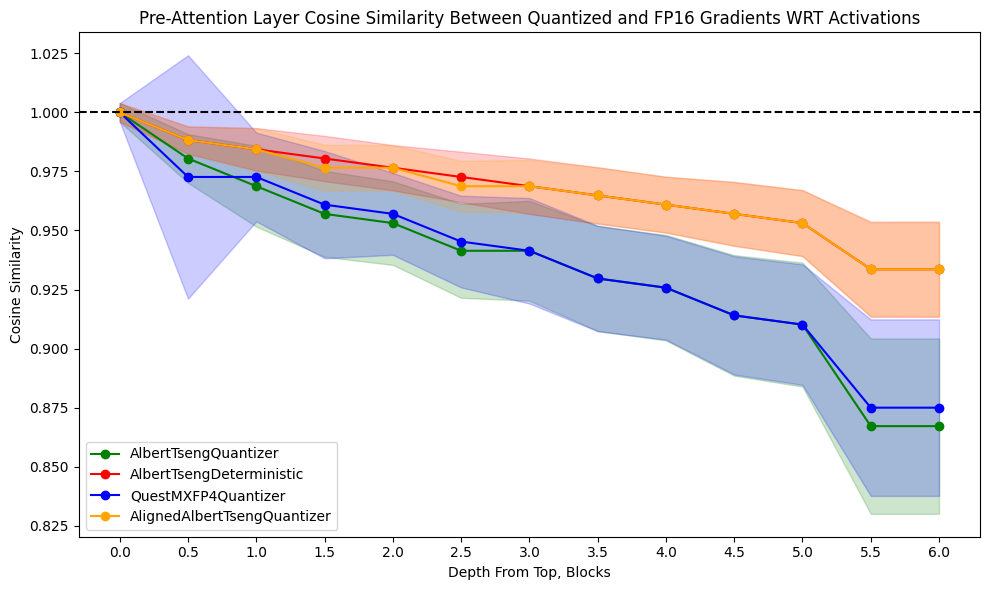

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def depth_from_name(name):
    idx = int(name.split(".")[3])
    depth = 5 - idx
    if "attn" in name:
        depth += 0.5
    return depth

# Define quantizers to plot
quantizers_to_plot = ["AlbertTsengQuantizer", "AlbertTsengDeterministic", "QuestMXFP4Quantizer", "AlignedAlbertTsengQuantizer"]
colors = ['green', 'red', 'blue', 'orange']

plt.figure(figsize=(10, 6))

# Process data for each quantizer
for i, quantizer in enumerate(quantizers_to_plot):
    data = OUTPUT_COSINE_SIMILARITIES[quantizer]
    
    # Initialize lists to store processed data
    x_values = []
    means = []
    stds = []
    
    # Process each key
    for key, values in data.items():
        x_val = depth_from_name(key)
        x_values.append(x_val)
        means.append(values['cosine_mean'])
        stds.append(values['cosine_std'])
    
    # Sort the data based on x_values
    sorted_indices = np.argsort(x_values)
    x_sorted = np.array(x_values)[sorted_indices]
    means_sorted = np.array(means)[sorted_indices]
    stds_sorted = np.array(stds)[sorted_indices]
    
    # Plot the data for this quantizer
    plt.plot(x_sorted, means_sorted, marker='o', linestyle='-', color=colors[i], label=f'{quantizer}')
    
    # Add shaded region for standard deviation
    plt.fill_between(
        x_sorted,
        means_sorted - stds_sorted,
        means_sorted + stds_sorted,
        color=colors[i],
        alpha=0.2
    )

# Customize the plot
plt.axhline(y=1.0, color='black', linestyle='--')
plt.title('Pre-Attention Layer Cosine Similarity Between Quantized and FP16 Gradients WRT Activations')
plt.xlabel('Depth From Top, Blocks')
plt.ylabel('Cosine Similarity')
plt.xticks(sorted(list(set(x_sorted))))  # Ensure x-axis has unique ticks
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()


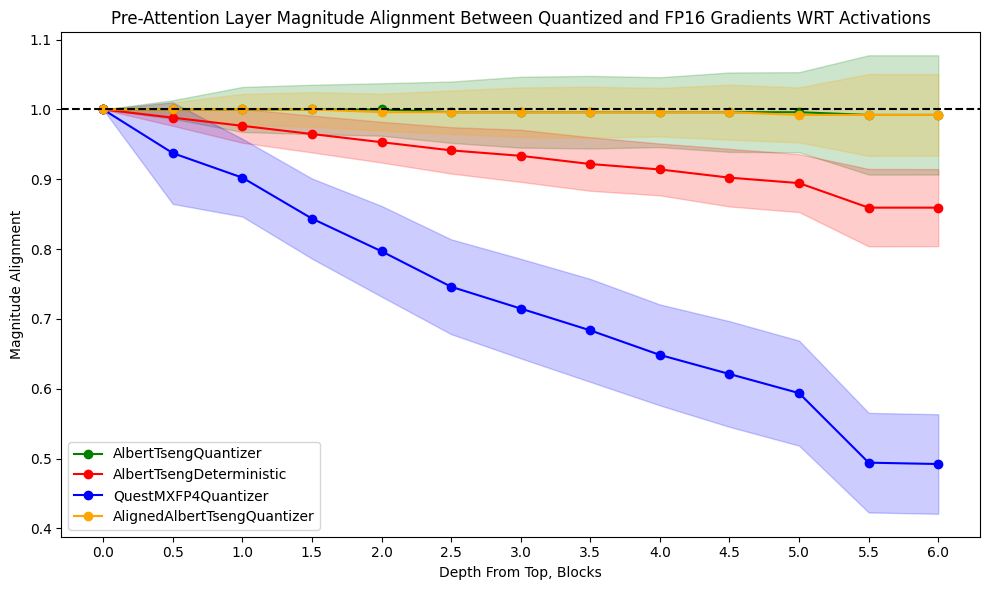

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def depth_from_name(name):
    idx = int(name.split(".")[3])
    depth = 5 - idx
    if "attn" in name:
        depth += 0.5
    return depth

# Define quantizers to plot
quantizers_to_plot = ["AlbertTsengQuantizer", "AlbertTsengDeterministic", "QuestMXFP4Quantizer", "AlignedAlbertTsengQuantizer"]
colors = ['green', 'red', 'blue', 'orange']

plt.figure(figsize=(10, 6))

# Process data for each quantizer
for i, quantizer in enumerate(quantizers_to_plot):
    data = OUTPUT_COSINE_SIMILARITIES[quantizer]
    
    # Initialize lists to store processed data
    x_values = []
    means = []
    stds = []
    
    # Process each key
    for key, values in data.items():
        x_val = depth_from_name(key)
        x_values.append(x_val)
        means.append(values['alignment_mean'])
        stds.append(values['alignment_std'])
    
    # Sort the data based on x_values
    sorted_indices = np.argsort(x_values)
    x_sorted = np.array(x_values)[sorted_indices]
    means_sorted = np.array(means)[sorted_indices]
    stds_sorted = np.array(stds)[sorted_indices]
    
    # Plot the data for this quantizer
    plt.plot(x_sorted, means_sorted, marker='o', linestyle='-', color=colors[i], label=f'{quantizer}')
    
    # Add shaded region for standard deviation
    plt.fill_between(
        x_sorted,
        means_sorted - stds_sorted,
        means_sorted + stds_sorted,
        color=colors[i],
        alpha=0.2
    )

# Customize the plot
plt.axhline(y=1.0, color='black', linestyle='--')
plt.title('Pre-Attention Layer Magnitude Alignment Between Quantized and FP16 Gradients WRT Activations')
plt.xlabel('Depth From Top, Blocks')
plt.ylabel('Magnitude Alignment')
plt.xticks(sorted(list(set(x_sorted))))  # Ensure x-axis has unique ticks
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()
